In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os 
from tqdm import tqdm

In [2]:
from src.data.prepare_data import parse_data, clean_data, sample_sparse_row
from src.data.make_dataset import cut_texts

Объединим все csv файлы в папке data/raw в один DataFrame

In [3]:
full_df = parse_data('../data/raw')
full_df.head()

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:22<00:00,  1.06s/it]


,id,published_date,title,language,topic,link,country,summary,label
0,8df4cbef454b703efc1fa2182fa19464,2022-11-15 18:35:33,RFID Anti-Counterfeiting Tag market: Market Pl...,en,business,https://www.openpr.com/news/2808352/rfid-anti-...,DE,RFID Anti-Counterfeiting Tag market: Market Pl...,anti-counterfeit
1,55e4319b28151bf88de62331a9d78935,2022-11-11 03:18:53,Global Anti-Counterfeit Packaging Market SWOT ...,en,business,https://www.openpr.com/news/2802747/global-ant...,DE,Global Anti-Counterfeit Packaging Market SWOT ...,anti-counterfeit
2,c68aacc054eeb27cba80e2fcd5874a1a,2022-11-08 07:28:42,Holographic Anti-Counterfeiting Marks Market C...,en,news,https://heraldkeeper.com/market/holographic-an...,unknown,Holographic Anti-Counterfeiting Marks Market C...,anti-counterfeit
3,6ae385eb692157ceeee345815c224cf0,2022-11-29 01:29:13,Anti-counterfeit Pharmaceutical Packaging Mark...,en,news,https://www.taiwannews.com.tw/en/news/4735391,TW,Research Viewpoint on Anti-counterfeit Pharmac...,anti-counterfeit
4,d40e2137da838ddc33cdc66f4e964afa,2022-11-03 14:15:23,Anti-Counterfeit Packaging Market Growth Prosp...,en,news,https://www.openpr.com/news/2791697/anti-count...,DE,Anti-Counterfeit Packaging Market Growth Prosp...,anti-counterfeit


In [4]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 401034 entries, 0 to 83358
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   id              401034 non-null  object
 1   published_date  401034 non-null  object
 2   title           401033 non-null  object
 3   language        401034 non-null  object
 4   topic           401012 non-null  object
 5   link            401034 non-null  object
 6   country         401034 non-null  object
 7   summary         400007 non-null  object
 8   label           401034 non-null  object
dtypes: object(9)
memory usage: 30.6+ MB


Для наглядности и простоты вычислений каждому тексту назначим ункиальный номер

In [5]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
full_df.loc[:, "text_id"] = le.fit_transform(
    full_df.summary
)  # Unique id for unique text

In [6]:
full_df.text_id.value_counts()

text_id
245759    1027
123058     927
49671      492
21689      435
121896     308
          ... 
84832        1
75518        1
170138       1
130854       1
88811        1
Name: count, Length: 245760, dtype: int64

Исходя из задания мы должны делать прогноз по тексту, он представлен в столбце summary. 
Данные у которых Nan в данном столбце можно отбросить. 
Очистим данные от дублирующего теста, представим целевой признак в виде OneHotEncode вектора

In [7]:
clean_df = clean_data(full_df)

In [8]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 245759 entries, 0 to 295488
Data columns (total 30 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   id                                      245759 non-null  object
 1   published_date                          245759 non-null  object
 2   title                                   245758 non-null  object
 3   language                                245759 non-null  object
 4   topic                                   245741 non-null  object
 5   link                                    245759 non-null  object
 6   country                                 245759 non-null  object
 7   summary                                 245759 non-null  object
 8   text_id                                 245759 non-null  int32 
 9   encodded_label_CASB                     245759 non-null  int64 
 10  encodded_label_EDR                      245759 non-null  int6

#### Рассмотрим распределение целевого признака

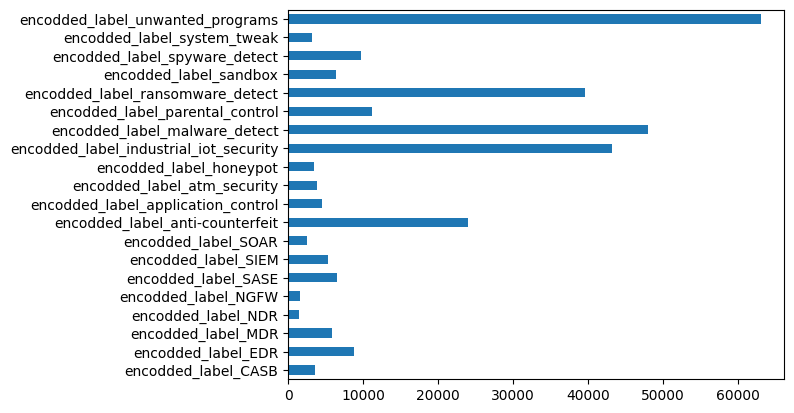

In [9]:
label_names = [col for col in clean_df.columns if 'encodded_label' in col]
clean_df[label_names].sum().plot(kind='barh');

In [10]:
(clean_df[label_names].sum() / clean_df.shape[0])[(clean_df[label_names].sum() / clean_df.shape[0]) < 0.02]

encodded_label_CASB                   0.014364
encodded_label_NDR                    0.005668
encodded_label_NGFW                   0.006600
encodded_label_SOAR                   0.009953
encodded_label_application_control    0.018193
encodded_label_atm_security           0.015580
encodded_label_honeypot               0.014152
encodded_label_system_tweak           0.013013
dtype: float64

Распределение признаков сильно не сбалансированное, поэтому применим технику downsampling. 
Тексты принадлежащие нескольким  классам оставляем неизменными, тексты которые относятся только к одному классу
сэмплируем до достижения доли в 5% в общем балансе классов

In [11]:
processed_df = sample_sparse_row(clean_df)

In [12]:
processed_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 64388 entries, 254 to 239171
Data columns (total 30 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   id                                      64388 non-null  object
 1   published_date                          64388 non-null  object
 2   title                                   64387 non-null  object
 3   language                                64388 non-null  object
 4   topic                                   64384 non-null  object
 5   link                                    64388 non-null  object
 6   country                                 64388 non-null  object
 7   summary                                 64388 non-null  object
 8   text_id                                 64388 non-null  int32 
 9   encodded_label_CASB                     64388 non-null  int64 
 10  encodded_label_EDR                      64388 non-null  int64 
 11  enco

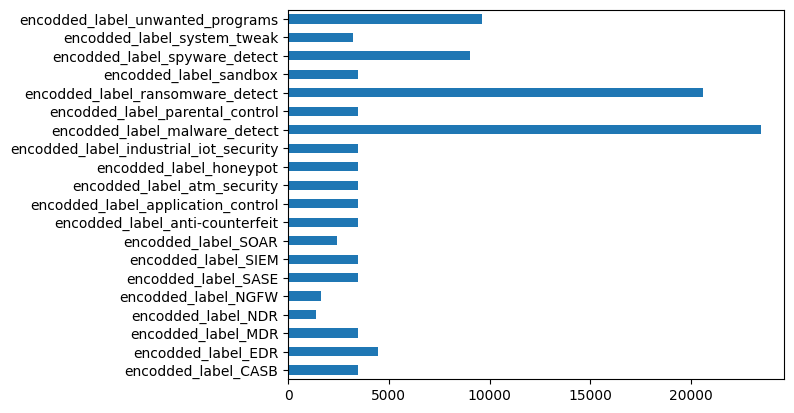

In [13]:
processed_df[label_names].sum().plot(kind='barh');

In [14]:
processed_df[label_names].sum() / processed_df.shape[0]

encodded_label_CASB                       0.054078
encodded_label_EDR                        0.069004
encodded_label_MDR                        0.054078
encodded_label_NDR                        0.021634
encodded_label_NGFW                       0.025191
encodded_label_SASE                       0.054078
encodded_label_SIEM                       0.054078
encodded_label_SOAR                       0.037988
encodded_label_anti-counterfeit           0.054078
encodded_label_application_control        0.054078
encodded_label_atm_security               0.054078
encodded_label_honeypot                   0.054016
encodded_label_industrial_iot_security    0.054078
encodded_label_malware_detect             0.364400
encodded_label_parental_control           0.054078
encodded_label_ransomware_detect          0.319858
encodded_label_sandbox                    0.054078
encodded_label_spyware_detect             0.140011
encodded_label_system_tweak               0.049668
encodded_label_unwanted_program

Рассмотрим размер наших текстов 

In [15]:
import re
def count_words(text):
    n = len(text.split())
    return n

processed_df['num_words'] = processed_df.summary.map(count_words)

In [16]:
processed_df.num_words.describe()

count     64388.000000
mean       1016.157731
std        1372.420266
min           4.000000
25%         554.000000
50%         833.000000
75%        1210.000000
max      212343.000000
Name: num_words, dtype: float64

Традиционные модели трансформеров Bert принимают до 512 токенов. Поэтому обрежем все токены начиная с 513 в наших текстах

In [17]:
processed_df['cutted_text'] = processed_df.summary.map(cut_texts)

Теперь наши данные готовы к обучению 